# Connecting to MIMIC

I took the following from https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/tutorials/cohort-selection.ipynb

What I have done was download the data to my local home server (it was very slow, took about 5 hours). I then used the repository I linked above and converted the csv files into a postgres database, which I can now access locally!

The below works on my machine when running the database:

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg
from sqlalchemy import create_engine, text
# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'davidscott'
dbname = 'mimic'
schema_name = 'mimiciii'
port = 5432
host = "localhost"
password="postgres"

connection_url = f"postgresql+psycopg://{sqluser}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_url)

# Connect to postgres with a copy of the MIMIC-III database
# con = psycopg.connect(dbname=dbname, user=sqluser, password="postgres")

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'


In [3]:
query = """
SELECT
	SUBJECT_ID,
	HADM_ID,
	ICUSTAY_ID
FROM
	mimiciii.ICUSTAYS
LIMIT
	100
 """
con = engine.connect()
df = pd.read_sql_query(query, con)
df.head(10)


,subject_id,hadm_id,icustay_id
0,268,110404,280836
1,269,106296,206613
2,270,188028,220345
3,271,173727,249196
4,272,164716,210407
5,273,158689,241507
6,274,130546,254851
7,275,129886,219649
8,276,135156,206327
9,277,171601,272866


# 5.1 "Surprising Distribution of Heart Rates"

## Figure 2 Recreation

### looks like we want to include 211, 220045 ... and potentially 5972 (fetal heart rate)

In [4]:
# heart rates
query = """
SELECT
    c.subject_id,
    c.hadm_id,
    c.icustay_id,
    c.charttime,
    c.value AS heart_rate,
    EXTRACT(YEAR FROM AGE(c.charttime, p.dob)) AS age -- Adjusted to prevent negative ages
FROM
     mimiciii.chartevents c
JOIN
    mimiciii.patients p ON c.subject_id = p.subject_id
WHERE
    c.itemid IN (220045, 211, 5972)  -- Include the specified item IDs
    AND c.value IS NOT NULL
ORDER BY
    c.charttime;

"""
con = engine.connect()
heart = pd.read_sql_query(query, con)
heart.head(10)

,subject_id,hadm_id,icustay_id,charttime,heart_rate,age
0,82574,118464,202134.0,2100-06-08 00:18:00,68,56.0
1,82574,118464,202134.0,2100-06-08 01:00:00,59,56.0
2,82574,118464,202134.0,2100-06-08 02:00:00,58,56.0
3,82574,118464,202134.0,2100-06-08 02:30:00,60,56.0
4,82574,118464,202134.0,2100-06-08 02:44:00,69,56.0
5,82574,118464,202134.0,2100-06-08 02:45:00,63,56.0
6,82574,118464,202134.0,2100-06-08 03:00:00,60,56.0
7,82574,118464,202134.0,2100-06-08 03:15:00,61,56.0
8,82574,118464,202134.0,2100-06-08 03:30:00,60,56.0
9,82574,118464,202134.0,2100-06-08 04:00:00,60,56.0


In [5]:
heart['heart_rate'] = pd.to_numeric(heart['heart_rate'], errors='coerce')
print("Number of NaN values in heart_rate:", heart['heart_rate'].isnull().sum())
print("Mean Heart Rate:", heart['heart_rate'].mean())
print("Median Heart Rate:", heart['heart_rate'].median())
print("Mean Age:", heart['age'].mean())
print("Median Age:", heart['age'].median())
print("Min Age:", heart['age'].min())
print("Max Age:", heart['age'].max())

Number of NaN values in heart_rate: 0
Mean Heart Rate: 102.66196480034685
Median Heart Rate: 92.0
Mean Age: 57.427613995154296
Median Age: 60.0
Min Age: 0.0
Max Age: 310.0


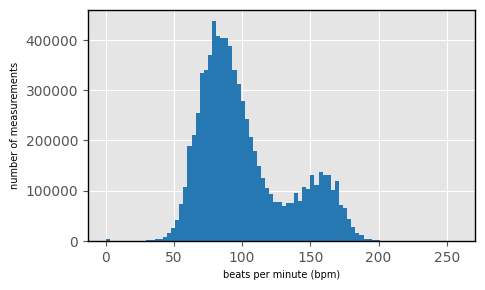

In [6]:
# Create bins for heart rate intervals (0-10, 10-20, ..., 240-250) I think this is what the image above is doing? 
bins = range(0, 260, 3) 
fig, ax = plt.subplots(1,1,figsize=(5, 3))
plt.setp(ax.spines.values(), lw=1, color='black')
ax.ticklabel_format(axis='y', style='plain')
ax.hist(heart['heart_rate'], bins=bins, color='#2678b2') 
ax.set_xlabel('beats per minute (bpm)', fontsize=7, color='black')  # Label for x-axis
ax.set_ylabel('number of measurements', fontsize=7, color='black')  # Label for y-axis
plt.show() 

Can we recreate figure 2 from section 5.1 now?

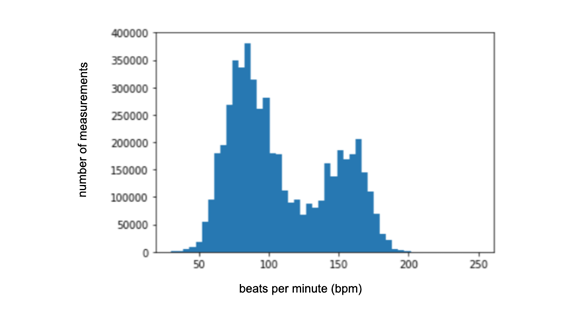

Looks like we sort of have figure 2. I still want to confirm this with David.. the peaks line up, but the only thing that seems to be off is the total number of records. We max out around 1.4 million, while the figure 2 from the paper maxes out around 4 million. 

## Figure 3 Recreation

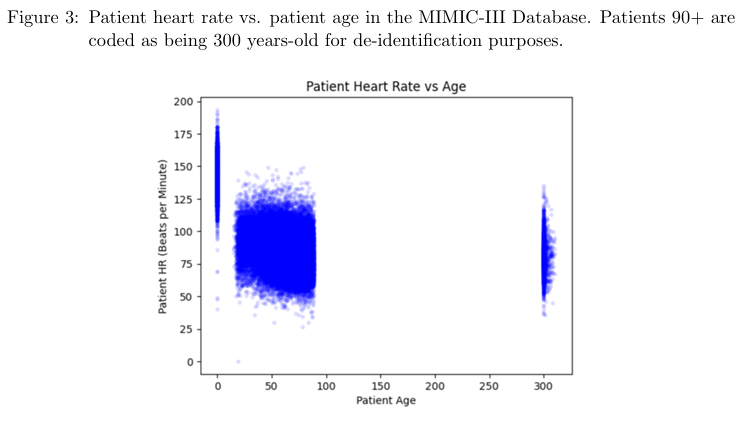

The purpose of this visual is two-fold (as described by the paper)
1. The difference in physiology of older humans and newborns is seen by the much higher heart rates seen around age 0
2. The giant gap in age from ~90 to 300. Why is this? The paper explains that all patients older than 90 are grouped together in a 300+ bin to avoid making it obvious who a person is based on their rare age

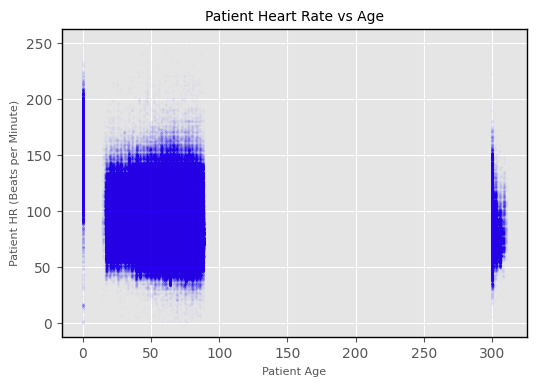

In [7]:
heart = heart[(heart['heart_rate'] > 0) & (heart['heart_rate'] <= 250)]
fig, ax = plt.subplots(1,1,figsize=(6, 4))
plt.setp(ax.spines.values(), lw=1, color='black')
# Adjusting the alpha value for transparency; set lower value for more transparency
plt.scatter(heart['age'], heart['heart_rate'], alpha=0.01, color='#2600ff', s=2)  
plt.xlabel('Patient Age', fontsize=8) 
plt.ylabel('Patient HR (Beats per Minute)', fontsize=8)  
plt.title('Patient Heart Rate vs Age', fontsize=10)  
plt.show()  

Looks pretty close, don't you think? The key here is adjusting the alpha to make the dots really transparent since there is so much data that needs to fit on a single line. Not sure what is going on with the horizontal line there at the bottom.. maybe we should exclude all heart rates of 0 and chalk that up to improper measurements?

# 5.2 "Inconsistent Timestamps"

In [8]:
# get all ICU stays with their associated hospital admission/discharge times
query = """
SELECT 
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    a.admittime AS hospital_admittime,
    i.intime AS icu_intime,
    i.outtime AS icu_outtime,
    a.dischtime AS hospital_dischtime,
    -- Check if ICU intime is before hospital admission
    CASE WHEN i.intime < a.admittime THEN 1 ELSE 0 END AS icu_before_hosp_admit,
    -- Check if ICU outtime is after hospital discharge
    CASE WHEN i.outtime > a.dischtime THEN 1 ELSE 0 END AS icu_after_hosp_discharge,
    -- Calculate time differences for cases where order is wrong
    EXTRACT(EPOCH FROM (a.admittime - i.intime))/60 AS minutes_icu_before_hosp,
    EXTRACT(EPOCH FROM (i.outtime - a.dischtime))/60 AS minutes_icu_after_hosp
FROM 
    mimiciii.icustays i
JOIN 
    mimiciii.admissions a ON i.hadm_id = a.hadm_id
"""
con = engine.connect()
timestamp_data = pd.read_sql_query(query, con)

In [10]:
# Calculate the statistics mentioned in the text
total_stays = len(timestamp_data)
print(f"Total ICU stays examined: {total_stays:,}")

# Calculate stays with all timestamps in correct order
correct_order = timestamp_data[
    (timestamp_data['icu_intime'] >= timestamp_data['hospital_admittime']) &
    (timestamp_data['icu_outtime'] <= timestamp_data['hospital_dischtime'])
]
correct_percentage = len(correct_order) / total_stays * 100
print(f"Percentage with correct chronological order: {correct_percentage:.0f}%")

# Calculate stays with at least one inconsistency
inconsistent_stays = timestamp_data[
    (timestamp_data['icu_intime'] < timestamp_data['hospital_admittime']) |
    (timestamp_data['icu_outtime'] > timestamp_data['hospital_dischtime'])
]
print(f"Stays with at least one inconsistency: {len(inconsistent_stays):,}")

# Cases where ICU intime is before hospital admission
icu_before_hosp = timestamp_data[timestamp_data['icu_intime'] < timestamp_data['hospital_admittime']]
print(f"ICU intime before hospital admission: {len(icu_before_hosp):,}")

# Cases where ICU outtime is after hospital discharge
icu_after_hosp = timestamp_data[timestamp_data['icu_outtime'] > timestamp_data['hospital_dischtime']]
print(f"ICU outtime after hospital discharge: {len(icu_after_hosp):,}")

# Cases where outtime and dischtime are within 10 minutes
within_10_min = icu_after_hosp[
    (icu_after_hosp['minutes_icu_after_hosp'] <= 10) & 
    (icu_after_hosp['minutes_icu_after_hosp'] >= 0)
]
print(f"ICU outtime after discharge but within 10 minutes: {len(within_10_min):,}")

# Cases where the difference is within 6 hours (360 minutes)
within_6_hours = icu_after_hosp[
    (icu_after_hosp['minutes_icu_after_hosp'] <= 360) & 
    (icu_after_hosp['minutes_icu_after_hosp'] >= 0)
]
percentage_within_6_hours = len(within_6_hours) / len(icu_after_hosp) * 100
print(f"Percentage of ICU-after-hospital cases within 6 hours: {percentage_within_6_hours:.0f}%")

Total ICU stays examined: 61,532
Percentage with correct chronological order: 80%
Stays with at least one inconsistency: 12,338
ICU intime before hospital admission: 486
ICU outtime after hospital discharge: 11,886
ICU outtime after discharge but within 10 minutes: 2,407
Percentage of ICU-after-hospital cases within 6 hours: 90%


All align so far with what was mentioned. 

# 5.3 "Lab Values Vary by Time of Day"

In [59]:
# Query to get WBC measurements with timestamps and flag for abnormal values
query = """
SELECT 
    l.subject_id,
    l.hadm_id,
    l.charttime,
    EXTRACT(HOUR FROM l.charttime) as hour_of_day,
    EXTRACT(MINUTE FROM l.charttime) AS minute_of_day,
    l.valuenum AS wbc_value,  -- In K/µL (4.5–11.0 is normal)
    CASE 
        WHEN l.valuenum BETWEEN 4.5 AND 11.0 THEN 0  -- Normal
        ELSE 1                                       -- Abnormal
    END AS is_abnormal
FROM 
    mimiciii.labevents l
WHERE 
    l.itemid IN (51300, 51301)  -- ONLY total WBC counts
    AND l.valuenum IS NOT NULL
    AND l.valuenum > 0  -- Exclude invalid values.. should we do this?
"""
con = engine.connect()
wbc_data = pd.read_sql_query(query, con)

## Figure 5 Recreation

,subject_id,hadm_id,charttime,hour_of_day,minute_of_day,wbc_value,is_abnormal
0,3,NaN,2101-10-14 03:00:00,3.0,0.0,9.9,0
1,3,145834.0,2101-10-20 19:26:00,19.0,26.0,11.3,1
2,3,145834.0,2101-10-20 19:59:00,19.5,59.0,19.1,1
3,2,163353.0,2138-07-17 20:48:00,20.5,48.0,0.1,1
4,2,163353.0,2138-07-17 21:10:00,21.0,10.0,22.0,1
...,...,...,...,...,...,...,...
755166,98759,175386.0,2165-06-06 01:44:00,1.5,44.0,6.0,0
755167,99283,166869.0,2125-12-08 04:45:00,4.5,45.0,11.5,1
755168,99002,NaN,2196-01-26 10:00:00,10.0,0.0,6.9,0
755169,99002,NaN,2196-01-29 12:40:00,12.5,40.0,7.3,0


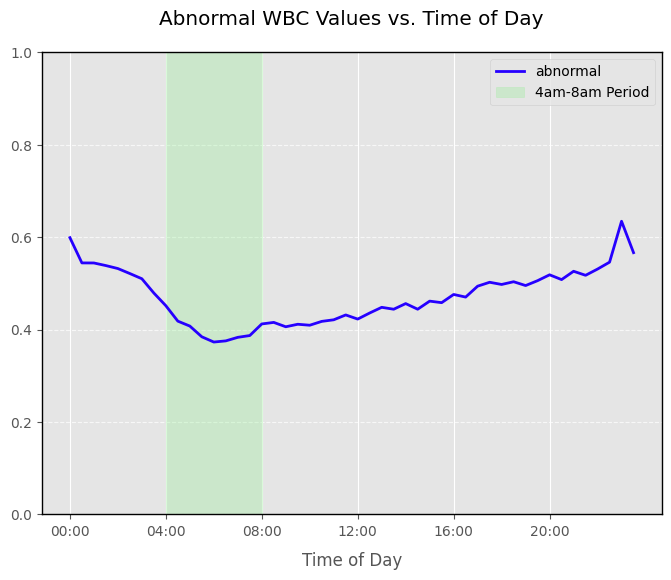

Total WBC measurements: 755,171
Overall percentage abnormal: 45.4%


In [ ]:
import matplotlib.ticker as ticker
# if minute >=30, add 0.5 to hour of day
wbc_data['hour_of_day'] = wbc_data.apply(lambda row: row['hour_of_day'] + 0.5 if row['minute_of_day'] >= 30 else row['hour_of_day'], axis=1)
# display(wbc_data)

hourly_stats = wbc_data.groupby('hour_of_day').agg(
    total_measurements=('wbc_value', 'count'),
    abnormal_measurements=('is_abnormal', 'sum')
).reset_index()

# Calculate percentage abnormal per hour
hourly_stats['pct_abnormal'] = (hourly_stats['abnormal_measurements'] / 
                                hourly_stats['total_measurements'])

hourly_stats = hourly_stats.sort_values('hour_of_day')

# Plot the results as a line chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8, 6))
line = plt.plot(hourly_stats['hour_of_day'], 
                hourly_stats['pct_abnormal'], 
                color='#2600ff',
                #marker='o',
                linewidth=2,
                #markersize=8,
                label='abnormal')

# Highlight the 4am-8am period with a shaded region
plt.axvspan(4, 8, color='lightgreen', alpha=0.3, label='4am-8am Period')
plt.setp(ax.spines.values(), lw=1, color='black')
plt.title('Abnormal WBC Values vs. Time of Day', pad=20)
plt.xlabel('Time of Day', labelpad=10)
#plt.ylabel('Percentage Abnormal', labelpad=10)
plt.xticks(range(0,24,4))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%02d'+':00'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)  # Percentage scale
plt.legend(loc='upper right')

plt.show()

# Print some summary statistics
print(f"Total WBC measurements: {len(wbc_data):,}")
print(f"Overall percentage abnormal: {wbc_data['is_abnormal'].mean()*100:.1f}%")

This looks pretty close to me.. maybe there is an itemid that gets the values closer? You can see that the most "normal" ranges for white blood cell counts appear between 4 and 8.

# 5.4 "Multiple Copies of Provider Notes"

In [61]:
# Query to extract all we would ever want to know about duplicate provider notes
query = """
WITH note_stats AS (
    SELECT 
        subject_id,
        hadm_id,
        charttime,
        category,
        description,
        COUNT(*) AS total_versions,
        COUNT(DISTINCT text) AS unique_text_versions,
        MIN(storetime) AS first_storetime,
        MAX(storetime) AS latest_storetime
    FROM 
        mimiciii.noteevents  
    WHERE 
        (iserror IS NULL OR iserror != '1')
        AND charttime IS NOT NULL
    GROUP BY 
        subject_id, hadm_id, charttime, category, description
)
SELECT 
    *,
    (total_versions - unique_text_versions) AS exact_duplicates,
    (total_versions - 1) AS potential_drafts
FROM 
    note_stats
ORDER BY 
    total_versions DESC;
"""

notes_df = pd.read_sql_query(query, con)

=== Duplicate Note Analysis ===
Total note groups: 1,489,455
Notes with multiple versions: 151,645
Maximum versions of a single note: 40
Average versions per note: 1.19
Notes with exact duplicates: 27,355
Notes with draft versions: 151,645


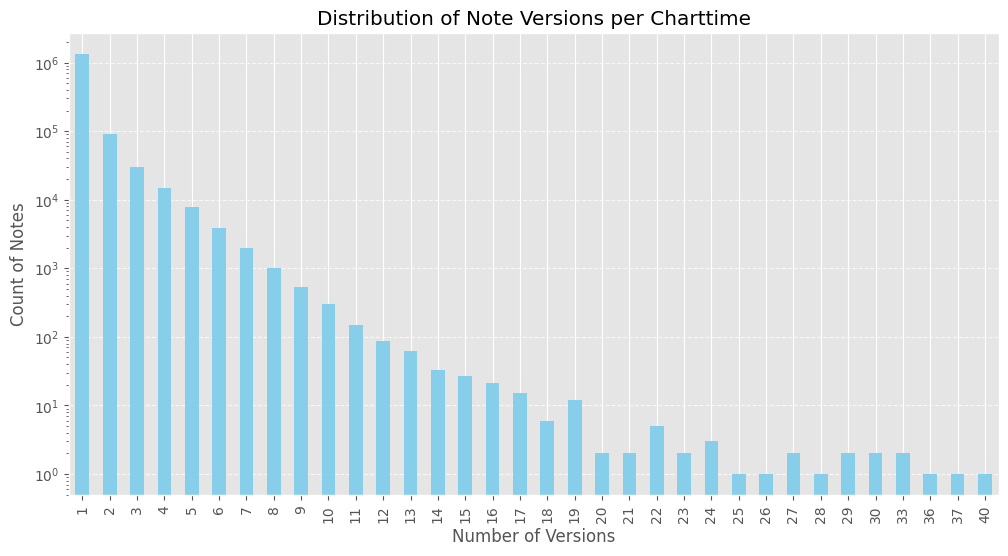


=== Breakdown by Note Category ===
                 total_versions              
                          count      mean max
category                                     
Nursing                   84465  2.625916  40
Physician                 62228  2.261120  17
Consult                      65  1.507692   6
Nutrition                  7295  1.287594  14
Social Work                2163  1.220065   7
General                    6994  1.171719  16
Rehab Services             4910  1.101018   5
Pharmacy                     91  1.098901   4
Radiology                497602  1.049592   4
Case Management             913  1.043812   3
Nursing/other            792048  1.038443  33
Respiratory               30681  1.032072   5


In [62]:
summary_stats = {
    "Total note groups": len(notes_df),
    "Notes with multiple versions": len(notes_df[notes_df['total_versions'] > 1]),
    "Maximum versions of a single note": notes_df['total_versions'].max(),
    "Average versions per note": round(notes_df['total_versions'].mean(), 2),
    "Notes with exact duplicates": len(notes_df[notes_df['exact_duplicates'] > 0]),
    "Notes with draft versions": len(notes_df[notes_df['potential_drafts'] > 0])
}

print("=== Duplicate Note Analysis ===")
for stat, value in summary_stats.items():
    print(f"{stat}: {value:,}")

# Plot distribution of note versions
plt.figure(figsize=(12, 6))
notes_df['total_versions'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    title='Distribution of Note Versions per Charttime'
)
plt.xlabel('Number of Versions')
plt.ylabel('Count of Notes')
plt.yscale('log')  # Log scale for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Breakdown by note category
category_stats = notes_df.groupby('category').agg({
    'total_versions': ['count', 'mean', 'max']
}).sort_values(('total_versions', 'mean'), ascending=False)

print("\n=== Breakdown by Note Category ===")
print(category_stats.to_string())

5.4 does not include any results proving this idea, from what I saw - but this is very interesting!

# 5.5 "Missing Death Date Collection"

The idea of this section is that, since there was a legislation change, post-discharge mortality rates make it seem like white people have a higher mortality rate than black people. This is proven to be false, so what is the reason?

https://github.com/wboag/eol-mort-pred/blob/main/eol-predict-2.0.ipynb

It is shown in this notebook, so we should recreate it.

** Note: running that notebook here failed for me.. because I was missing the status_codes table..

In [63]:
import pandas as pd
import tqdm
from collections import Counter, defaultdict
import pylab as pl
import random
import xgboost
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.calibration import calibration_curve
from scipy.stats import mannwhitneyu
from lifelines import KaplanMeierFitter

In [64]:
con = engine.connect()

In [65]:
# TODO: exclude patients who die in-hospital
cohort_query = '''
WITH T AS (
        SELECT subject_id, MAX(admittime) AS admittime
        FROM mimiciii.admissions 
        GROUP BY subject_id
        ),
     EOL as (
         select hadm_id
         from mimiciii.diagnoses_icd
         where icd9_code = 'V667'
     )
SELECT a.*, gender, dob, dod
FROM mimiciii.admissions a
    JOIN T ON T.subject_id = a.subject_id AND T.admittime = a.admittime
    JOIN mimiciii.patients  p on p.subject_id = a.subject_id
where a.hadm_id not in (select hadm_id from EOL)
and ((dod is null) or (dod :: date - dischtime ::date >= 3))
and a.discharge_location not in ('HOSPICE-HOME', 'HOSPICE-MEDICAL FACILITY', 'DEAD/EXPIRED')
and dod is not null
and (a.admittime :: date - dob ::date) / 365.25 >= 18
--and insurance = 'Medicare'
'''
cohort = pd.read_sql_query(cohort_query, con)
print(cohort.shape)
cohort.head()

(9165, 22)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,gender,dob,dod
0,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,SINGLE,UNKNOWN/NOT SPECIFIED,NaT,NaT,V-TACH,0,1,M,2054-05-04,2128-02-25
1,34,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,None,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1,M,1886-07-18,2192-01-30
2,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,M,2114-09-17,2185-01-06
3,42,41,101757,2132-12-31 10:30:00,2133-01-27 15:45:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DISC-TRAN TO FEDERAL HC,Private,...,SINGLE,WHITE,NaT,NaT,RIGHT BRAIN STEM LESION/SDA,0,1,M,2076-05-13,2133-09-30
4,460,357,117876,2199-12-21 22:37:00,2200-01-18 11:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,MARRIED,WHITE,2199-12-21 20:38:00,2199-12-22 00:01:00,ALTERED MENTAL STATUS,0,1,M,2135-03-22,2201-08-02


In [72]:
#-- This query extracts:
#--    i) a patient's first code status
#--    ii) a patient's last code status
#--    iii) the time of the first entry of DNR or CMO
create_code_status_table = """
drop table if exists mimiciii.code_status; create table mimiciii.code_status as 
with t1 as
(
  select icustay_id, charttime, value
  -- use row number to identify first and last code status
  , ROW_NUMBER() over (PARTITION BY icustay_id order by charttime) as rnfirst
  , ROW_NUMBER() over (PARTITION BY icustay_id order by charttime desc) as rnlast

  -- coalesce the values
  , case
      when value in ('Full Code','Full code') then 1
    else 0 end as fullcode
  , case
      when value in ('Comfort Measures','Comfort measures only') then 1
    else 0 end as cmo
  , case
      when value = 'CPR Not Indicate' then 1
    else 0 end as dncpr -- only in CareVue, i.e. only possible for ~60-70% of patients
  , case
      when value in ('Do Not Intubate','DNI (do not intubate)','DNR / DNI') then 1
    else 0 end as dni
  , case
      when value in ('Do Not Resuscita','DNR (do not resuscitate)','DNR / DNI') then 1
    else 0 end as dnr
  FROM mimiciii.chartevents
  where itemid in (128, 223758)
  and value is not null
  and value != 'Other/Remarks'
  -- exclude rows marked as error
  AND (error IS NULL OR error = 0)
)
select ie.subject_id, ie.hadm_id, ie.icustay_id
  -- first recorded code status
  , max(case when rnfirst = 1 then t1.fullcode else null end) as fullcode_first
  , max(case when rnfirst = 1 then t1.cmo else null end) as cmo_first
  , max(case when rnfirst = 1 then t1.dnr else null end) as dnr_first
  , max(case when rnfirst = 1 then t1.dni else null end) as dni_first
  , max(case when rnfirst = 1 then t1.dncpr else null end) as dncpr_first

  -- last recorded code status
  , max(case when  rnlast = 1 then t1.fullcode else null end) as fullcode_last
  , max(case when  rnlast = 1 then t1.cmo else null end) as cmo_last
  , max(case when  rnlast = 1 then t1.dnr else null end) as dnr_last
  , max(case when  rnlast = 1 then t1.dni else null end) as dni_last
  , max(case when  rnlast = 1 then t1.dncpr else null end) as DNCPR_last

  -- were they *at any time* given a certain code status
  , max(t1.fullcode) as fullcode
  , max(t1.cmo) as cmo
  , max(t1.dnr) as dnr
  , max(t1.dni) as dni
  , max(t1.dncpr) as dncpr

  -- time until their first DNR
  , min(case when t1.dnr = 1 then t1.charttime else null end)
        as dnr_first_charttime
  , min(case when t1.dni = 1 then t1.charttime else null end)
        as dni_first_charttime
  , min(case when t1.dncpr = 1 then t1.charttime else null end)
        as dncpr_first_charttime

  -- first code status of CMO
  , min(case when t1.cmo = 1 then t1.charttime else null end)
        as timecmo_chart

FROM mimiciii.icustays ie
left join t1
  on ie.icustay_id = t1.icustay_id
group by ie.subject_id, ie.hadm_id, ie.icustay_id, ie.intime;
"""
con = engine.connect()
con.execute(text(create_code_status_table))

In [73]:
codestatus_df = pd.read_sql_query('select * from mimiciii.code_status', con)

# get code statuses
codestatus = {}
for row in codestatus_df.itertuples():
    if row.fullcode_last == 1:
        cs = 'fullcode'
    elif row.cmo_last == 1:
        cs = 'cmo'
    elif row.dnr_last == 1:
        cs = 'dnr'
    elif row.dni_last == 1:
        cs = 'dni'
    elif row.dncpr_last == 1:
        cs = 'dncpr'
    else:
        cs = 'none'
        
    codestatus[row.hadm_id] = cs

In [74]:
cmo = set([hadm_id for hadm_id,cs in codestatus.items() if cs=='cmo'])
print(len(cmo))

cohort = cohort[~cohort.hadm_id.isin(cmo)]
print(cohort.shape)

1615
(9144, 22)


In [79]:
# -- ------------------------------------------------------------------
# -- Title: Detailed information on ICUSTAY_ID
# -- Description: This query provides a useful set of information regarding patient
# --              ICU stays. The information is combined from the admissions, patients, and
# --              icustays tables. It includes age, length of stay, sequence, and expiry flags.
# -- MIMIC version: MIMIC-III v1.3
# -- ------------------------------------------------------------------

# -- This query extracts useful demographic/administrative information for patient ICU stays
create_icustay_detail_table = """
drop table if exists mimiciii.icustay_detail; create table mimiciii.icustay_detail as 

SELECT ie.subject_id, ie.hadm_id, ie.icustay_id

-- patient level factors
, pat.gender, pat.dod

-- hospital level factors
, adm.admittime, adm.dischtime
, round((cast(extract(epoch from (adm.dischtime - adm.admittime))/(60*60*24) as numeric)), 8) as los_hospital
, round((cast(extract(epoch from (ie.intime - pat.dob))/(60*60*24*365) as numeric)), 8) as admission_age
, adm.ethnicity
, case when ethnicity in
  (
       'WHITE' --  40996
     , 'WHITE - RUSSIAN' --    164
     , 'WHITE - OTHER EUROPEAN' --     81
     , 'WHITE - BRAZILIAN' --     59
     , 'WHITE - EASTERN EUROPEAN' --     25
  ) then 'white'
  when ethnicity in
  (
      'BLACK/AFRICAN AMERICAN' --   5440
    , 'BLACK/CAPE VERDEAN' --    200
    , 'BLACK/HAITIAN' --    101
    , 'BLACK/AFRICAN' --     44
    , 'CARIBBEAN ISLAND' --      9
  ) then 'black'
  when ethnicity in
    (
      'HISPANIC OR LATINO' --   1696
    , 'HISPANIC/LATINO - PUERTO RICAN' --    232
    , 'HISPANIC/LATINO - DOMINICAN' --     78
    , 'HISPANIC/LATINO - GUATEMALAN' --     40
    , 'HISPANIC/LATINO - CUBAN' --     24
    , 'HISPANIC/LATINO - SALVADORAN' --     19
    , 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' --     13
    , 'HISPANIC/LATINO - MEXICAN' --     13
    , 'HISPANIC/LATINO - COLOMBIAN' --      9
    , 'HISPANIC/LATINO - HONDURAN' --      4
  ) then 'hispanic'
  when ethnicity in
  (
      'ASIAN' --   1509
    , 'ASIAN - CHINESE' --    277
    , 'ASIAN - ASIAN INDIAN' --     85
    , 'ASIAN - VIETNAMESE' --     53
    , 'ASIAN - FILIPINO' --     25
    , 'ASIAN - CAMBODIAN' --     17
    , 'ASIAN - OTHER' --     17
    , 'ASIAN - KOREAN' --     13
    , 'ASIAN - JAPANESE' --      7
    , 'ASIAN - THAI' --      4
  ) then 'asian'
  when ethnicity in
  (
       'AMERICAN INDIAN/ALASKA NATIVE' --     51
     , 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' --      3
  ) then 'native'
  when ethnicity in
  (
      'UNKNOWN/NOT SPECIFIED' --   4523
    , 'UNABLE TO OBTAIN' --    814
    , 'PATIENT DECLINED TO ANSWER' --    559
  ) then 'unknown'
  else 'other' end as ethnicity_grouped
  -- , 'OTHER' --   1512
  -- , 'MULTI RACE ETHNICITY' --    130
  -- , 'PORTUGUESE' --     61
  -- , 'MIDDLE EASTERN' --     43
  -- , 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' --     18
  -- , 'SOUTH AMERICAN' --      8
, adm.hospital_expire_flag
, DENSE_RANK() OVER (PARTITION BY adm.subject_id ORDER BY adm.admittime) AS hospstay_seq
, CASE
    WHEN DENSE_RANK() OVER (PARTITION BY adm.subject_id ORDER BY adm.admittime) = 1 THEN True
    ELSE False END AS first_hosp_stay

-- icu level factors
, ie.intime, ie.outtime
, round((cast(extract(epoch from (ie.outtime - ie.intime))/(60*60*24) as numeric)), 8) as los_icu
, DENSE_RANK() OVER (PARTITION BY ie.hadm_id ORDER BY ie.intime) AS icustay_seq

-- first ICU stay *for the current hospitalization*
, CASE
    WHEN DENSE_RANK() OVER (PARTITION BY ie.hadm_id ORDER BY ie.intime) = 1 THEN True
    ELSE False END AS first_icu_stay

FROM mimiciii.icustays ie
INNER JOIN mimiciii.admissions adm
    ON ie.hadm_id = adm.hadm_id
INNER JOIN mimiciii.patients pat
    ON ie.subject_id = pat.subject_id
WHERE adm.has_chartevents_data = 1
ORDER BY ie.subject_id, adm.admittime, ie.intime;
"""
con = engine.connect()
con.execute(text(create_icustay_detail_table))

In [80]:
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,ethnicity FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)

# filter demographics to the patients in the cohort
demographics = demographics[demographics.hadm_id.isin(set(cohort.hadm_id))]

print(demographics.shape)
demographics.head()

(8997, 4)


,subject_id,hadm_id,gender,ethnicity
9,7129,191192,M,WHITE
14,11218,119049,M,WHITE
16,7963,104409,M,WHITE
18,9867,118085,F,UNABLE TO OBTAIN
20,1636,150008,M,WHITE


In [81]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

demographics['race'] = demographics['ethnicity'].apply(normalize_race)

race_lookup = defaultdict(lambda:'unk')
race_lookup.update(dict(demographics[['hadm_id','race']].values))

In [82]:
# identify who dies within 6 months
died_within_6months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=180)]
died_within_12months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=365)]
died_postdisch = cohort[~cohort.dod.isnull()]

# label every patient as dying within 6 months or not
labels = {hadm_id:0 for hadm_id in cohort.hadm_id}
#for hadm_id in died_within_6months.hadm_id:
for hadm_id in died_within_12months.hadm_id:
#for hadm_id in died_postdisch.hadm_id:
    labels[hadm_id] = 1

print(len(labels))

# print positive percentage
print(sum(labels.values()) / len(labels))

9144
0.5138888888888888


In [83]:
print(len(labels))
print(len(set(demographics.hadm_id)))
print(len(set(cohort.hadm_id)))

9144
8997
9144


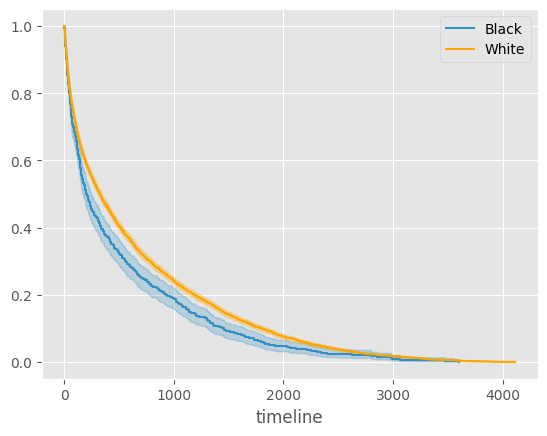

In [90]:
#died_postdisch
died_postdisch['race']  = [race_lookup[row.hadm_id] for row in died_postdisch.itertuples()]
ax = pl.subplot(111)
for race,rows in died_postdisch.groupby('race'):
    if race not in ['White', 'Black']: continue
        
    #print(race)
    #display(rows)
    times  = [t.days for t in (rows.dod - rows.dischtime)]
    
    kmf = KaplanMeierFitter()
    kmf.fit(durations = times, label=race)
    
    kmf.plot_survival_function(ax = ax, color='orange' if race=='White' else '#348fc2')

# 6.1 "Diagnosis Column"

In [97]:
# comparing the diagnosis column 
query = """
SELECT 
    a.HADM_ID, a.DIAGNOSIS, string_agg(icd_d.long_title,',')
FROM 
    mimiciii.admissions as a,
    mimiciii.diagnoses_icd as d,
    mimiciii.d_icd_diagnoses as icd_d
where
    a.HADM_ID=d.HADM_ID and
    d.icd9_code=icd_d.icd9_code
GROUP BY
    a.HADM_ID, a.DIAGNOSIS
"""

admitting_daignosis_df = pd.read_sql_query(query, con)
display(admitting_daignosis_df)



,hadm_id,diagnosis,string_agg
0,100001,DIABETIC KETOACIDOSIS,"Hematemesis,Acute kidney failure, unspecified,..."
1,100003,UPPER GI BLEED,Other specified disorders of stomach and duode...
2,100006,COPD FLARE,"Multiple myeloma, without mention of having ac..."
3,100007,BOWEL OBSTRUCTION,"Pneumonia, organism unspecified,Unspecified es..."
4,100009,CORONARY ARTERY DISEASE,Coronary atherosclerosis of native coronary ar...
...,...,...,...
58920,199993,CORONARY ARTERY DISEASE,"Hyperosmolality and/or hypernatremia,Unspecifi..."
58921,199994,MENTAL STATUS CHANGES,"Chronic pulmonary heart disease, unspecified,D..."
58922,199995,ROOT ABSCESS,"Thoracic aneurysm without mention of rupture,M..."
58923,199998,CORONARY ARTERY DISEASE,Coronary atherosclerosis of native coronary ar...
